# Unmapping

## Recovering data from scientific images is harder than it sounds

Matt Hall, Scout Team, EDB Lab, Bergen

Colab `swu.ng/2xHrMd` | Gist `swu.ng/iPrYKd` | CC BY-SA 2023 Scienxlab

Imagine I want to get the data from this image [CC BY-SA ]

<img src="https://i.stack.imgur.com/dAFPL.png" width=1200; />

Or this one [CC BY-SA Joshua Doubek / pickthis.io]

<img src="https://the-geophysicist.com/wp-content/uploads/2015/03/FlatSpotPickthis1.png" width=1200; />

## The recipe

- <span style="color:lightgray;">Get the data from the figure</span>
- Figure out the colours in the colourmap
- Put the colours in the right order
- Do a reverse look-up from colour to scalar
- <span style="color:lightgray;">Move the data to the right scale</span>

Under some assumptions:

- We know the polarity of the data
- We know the range of the data
- The data are spatial continous

## Start with some data

In [1]:
import scipy.ndimage as snd
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(1111)
raw = rng.random((300, 300))
arr = snd.gaussian_filter(raw, 15)
arr = (arr - arr.min()) / (arr.max() - arr.min())
arr[:5, :5]

array([[0.19770541, 0.1982454 , 0.19934656, 0.20095198, 0.20307213],
       [0.19888639, 0.19942497, 0.20052332, 0.20212445, 0.20423853],
       [0.20128211, 0.20181772, 0.20291015, 0.20450218, 0.20660354],
       [0.20488359, 0.20541459, 0.20649783, 0.20807578, 0.21015748],
       [0.20966076, 0.21018566, 0.21125674, 0.21281609, 0.21487181]])

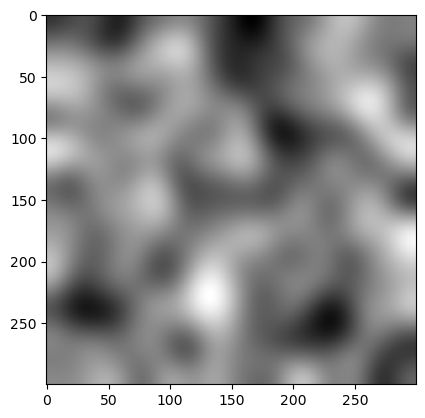

In [2]:
plt.imshow(arr, cmap='gray')


## Let's turn our data into an image

In [3]:
cmap = plt.get_cmap('jet')
rgb = cmap(arr)[..., :3]
rgb[0, :5]

array([[0.        , 0.28431373, 1.        ],
       [0.        , 0.28431373, 1.        ],
       [0.        , 0.3       , 1.        ],
       [0.        , 0.3       , 1.        ],
       [0.        , 0.3       , 1.        ]])

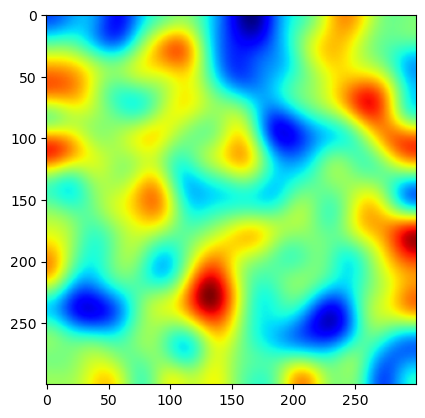

In [4]:
plt.imshow(rgb)

## Nearest-neighbour lookup

Fortunately, we know the colourmap.

In [5]:
clut = cmap(np.linspace(0, 1, 256))[..., :3]
clut[:5]

array([[0.        , 0.        , 0.5       ],
       [0.        , 0.        , 0.51782531],
       [0.        , 0.        , 0.53565062],
       [0.        , 0.        , 0.55347594],
       [0.        , 0.        , 0.57130125]])

In [6]:
from scipy.spatial import cKDTree

kdtree = cKDTree(clut)
dist, ix = kdtree.query(rgb)
rec = ix / ix.max()

## Recovered data and difference

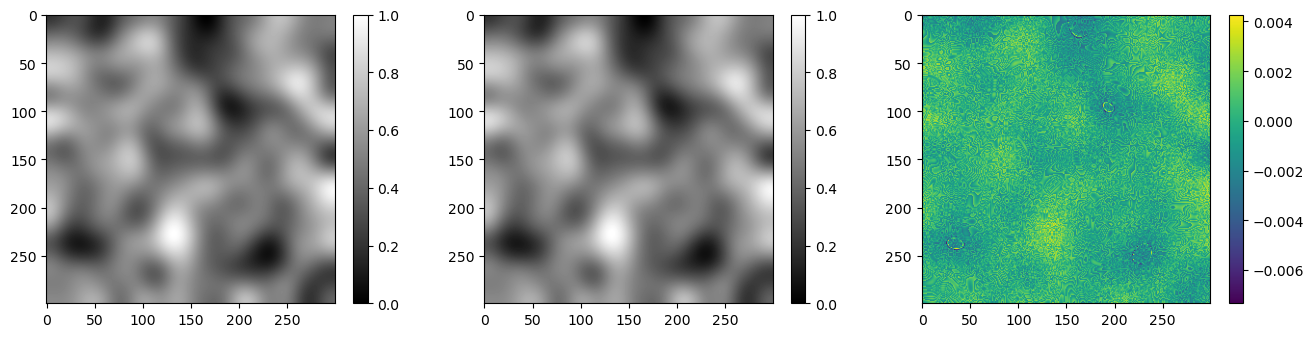

In [7]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 3.75))
im0 = ax0.imshow(arr, cmap='gray')
plt.colorbar(im0)
im1 = ax1.imshow(rec, cmap='gray')
plt.colorbar(im1)
im2 = ax2.imshow(rec - arr)
plt.colorbar(im2)

## But...

That's not really an image, and we knew the colourmap.

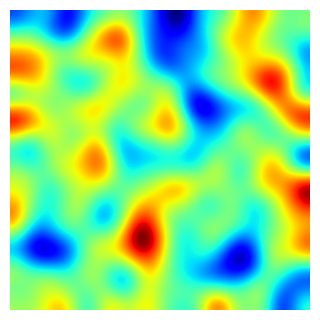

In [8]:
fig = plt.figure(frameon=False)
fig.set_size_inches(3, 3)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(arr, cmap='jet')

plt.savefig('test.jpg')
plt.savefig('test.png')

## JPEG colours

In [9]:
from PIL import Image

img = Image.open('test.jpg')
ima = np.asarray(img)[..., :3] / 255
ima1d = ima.reshape(-1, 3)

np.unique(ima1d, axis=0).shape

(18494, 3)

### Damn.

## Quantization

In practice, we need to **quantize** the image.

In [10]:
from sklearn.cluster import KMeans

clu = KMeans(n_clusters=128)
clu.fit(ima1d[::5])
centroids = np.clip(clu.cluster_centers_, 0, 1)
centroids[:5]

array([[0.20245322, 0.99837049, 0.75596741],
       [0.91697238, 0.98743411, 0.08344929],
       [0.00343809, 0.69043782, 0.99511147],
       [0.62283125, 0.99643494, 0.34682115],
       [0.99468851, 0.45098039, 0.00769422]])

## The centroids are the colourmap

...sort of.

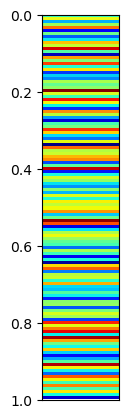

In [11]:
plt.figure(figsize=(1, 5))
extent = [0, 1, 1, 0]
plt.imshow(centroids.reshape(-1, 1, 3), aspect='auto', extent=extent)
plt.tick_params(axis='x', bottom=False, labelbottom=False)

## The quantized image

The information we need to sort is here.

In [12]:
idx = clu.predict(ima1d).reshape(300, 300)
idx

array([[49, 49, 49, ..., 98, 98, 98],
       [49, 49, 49, ..., 98, 98, 98],
       [49, 49, 49, ..., 98, 98, 15],
       ...,
       [74, 74, 74, ..., 81, 17, 17],
       [74, 74, 74, ..., 81, 17, 61],
       [74, 74, 74, ..., 17, 17, 61]], dtype=int32)

## Build a transition matrix

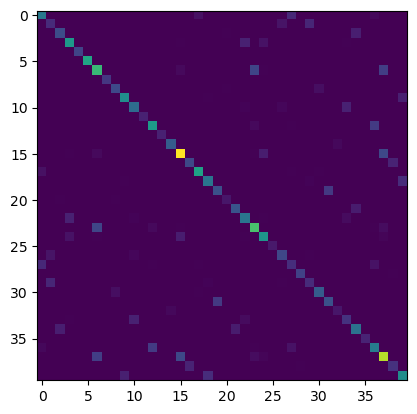

In [13]:
from skimage.feature import graycomatrix

glcm = graycomatrix(idx, distances=[1], levels=256,
                    angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                    symmetric=True)

glcm = np.sum(np.squeeze(glcm), axis=-1)

plt.imshow(glcm[:40, :40])

## The ordering problem

Create a graph, prune it, find the longest shortest path (the diametral path).

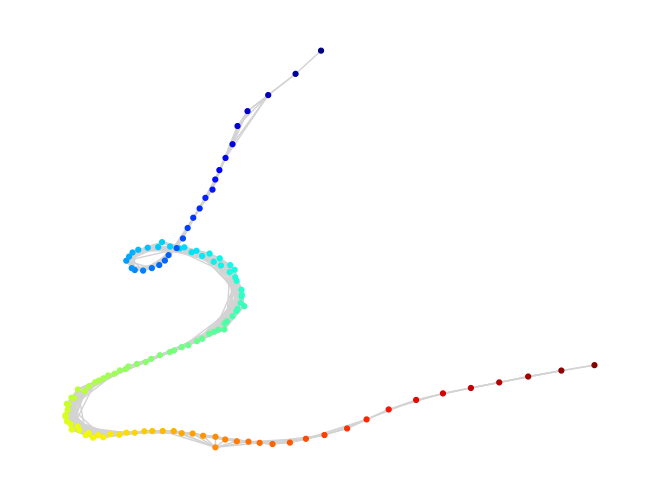

In [14]:
import networkx as nx

G = nx.from_numpy_array(glcm)
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len)
H = G.subgraph(Gcc[-1])

color = [centroids[n] for n in H]
layout = nx.spring_layout(H)
nx.draw(H, layout, node_size=12, node_color=color, edge_color='lightgray')

### Pruning

- Remove edges between vertices that have few transitions
- Remove edges between vertices that are distant in colour space
- Remove vertices with a large number of different neighbours
- Remove disconnected vertices.

Now find the longest shortest path between all connected vertices. This is the colourmap.

## Using `unmap`

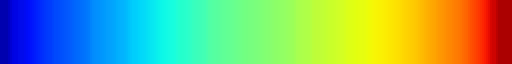

In [15]:
import unmap

cmap = unmap.guess_cmap_from_array(ima, equilibrate=True)

cmap

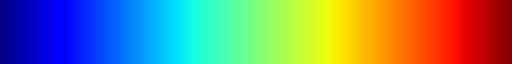

In [16]:
plt.get_cmap('jet')

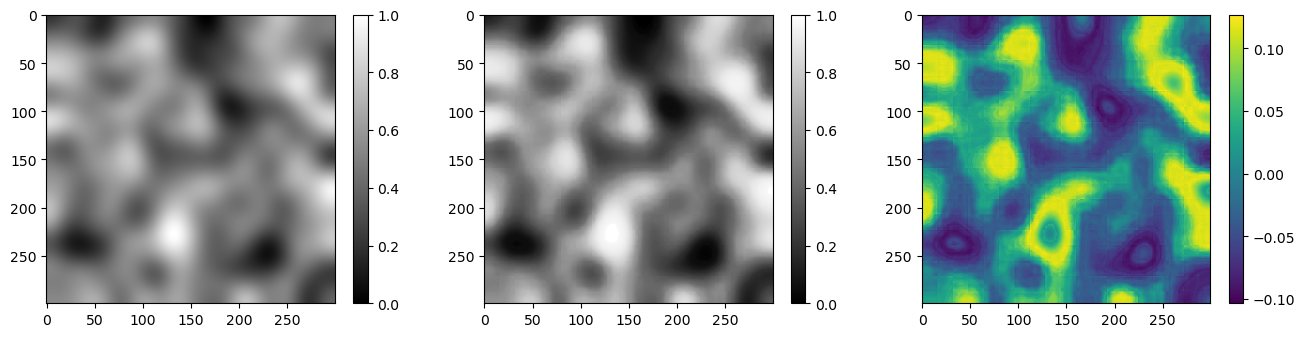

In [17]:
rec = unmap.unmap(ima, cmap, threshold=0.2)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 3.75))
im0 = ax0.imshow(arr, cmap='gray')
plt.colorbar(im0)
im1 = ax1.imshow(rec, cmap='gray')
plt.colorbar(im1)
im2 = ax2.imshow(rec - arr)
plt.colorbar(im2)

## With a PNG

JPEG is really bad, it does much better with a PNG.

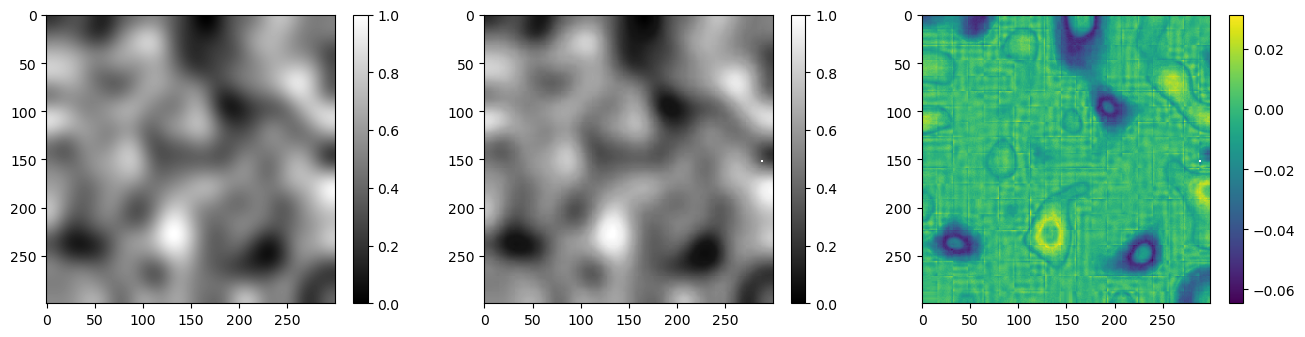

In [18]:
cmap = unmap.guess_cmap_from_image('test.png')
rec = unmap.unmap(ima, cmap)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 3.75))
im0 = ax0.imshow(arr, cmap='gray')
plt.colorbar(im0)
im1 = ax1.imshow(rec, cmap='gray')
plt.colorbar(im1)
im2 = ax2.imshow(rec - arr)
plt.colorbar(im2)

## Conclusion

- 80% of the time, it works every time
- It's really only an ordering problem
- There is some ML work to achieve this result
- What does a useful implementation look like?